\begin{equation*}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Nor}{\mathcal{N}}
\end{equation*}




# Due Dates

* Textbook: Thursday, November 1, in class
* Coding: Thursday, November 1, at 11:59 PM

# Textbook Problems

These problems are also coding-based. It may be helpful to do the first two coding exercises, which are related. 

* 3.39
* 3.41
* 3.43 (Use an Euler approximation to compute the time updates in discrete-time. The continuous-discrete unscented Kalman filter is outside of the scope of the class.)



In [1]:
# This is code to load the assignment.
# You'll need to run this code do or restart the assignment.
from loadAssignment import loadAssignment
Assignment, Questions, Submit, Data = loadAssignment(6)

# These are modules that we need
# once you run this code, you don't need to load them again
import autograd.numpy as np
import autograd as ag
import scipy.linalg as la
import scipy.integrate as itg
import matplotlib.pyplot as plt
%matplotlib inline




# Question 0





The first few problems in this assignment will be a warm-ups for the texbook problems. In particular, they will focus on coding continuous-time simulations of the Van der Pol System from example 3.5. That example focuses on the case of estimating the states of a nonlinear dynamic system when the parameters are incorrectly specified.

Assume that the initial condition is $x(0)=\left[\begin{matrix}1.0\\0.0\end{matrix}\right]$. 
Use [`itg.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to simulate the true Van der Pol system for 1000 time points spaced according to $\Delta t = 0.01$. Make a plot with $x_1(t)$ on the $x$-axis and $x_2(t)$ on the $y$-axis. 



Phenomenal
A score of 1 was entered for Question 0


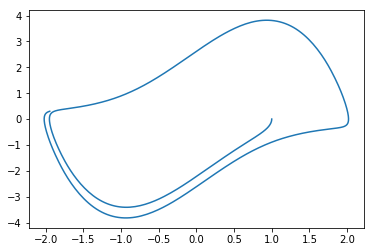

In [2]:
def vanderPolGen(t,x,c,m,k):
    return np.array([x[1],-2*(c/m)*(x[0]**2-1)*x[1]-(k/m)*x[0]])
    
def vanderPolTrueDrift(t,x):
    c = 1.
    m = 1.
    k = 1.
    
    return vanderPolGen(t,x,c,m,k)
    
    
def vanderPolGuessDrift(t,x):
    c = 1.5
    m = 1.
    k = 1.2
    return vanderPolGen(t,x,c,m,k)

Time = 0.01 * np.arange(1000)
x0 = np.array([1.,0.])
Res = itg.solve_ivp(vanderPolTrueDrift,(Time[0],Time[-1]),x0,t_eval=Time)
X = Res.y
plt.plot(X[0],X[1])
         
Questions[0].checkAnswer()


# Question 1

Assume that no measurements are taken. Using just the propagation equation from Table 3.9, the mean $\hat x(t)$ and $ P(t)$ can be simulated. Now use `itg.solve_ivp` to simulate $\hat x(t)$ and $P(t)$. As in example 3.5, for this simulation, assume that the mis-specified values are used. Also, as in the example, assume that $q =0.2$ and $P(0) = 1000 I$. Assume that $\hat x(0) = \left[\begin{matrix}1.0\\0.0\end{matrix}\right]	$

Note that in order to use `itg.solve_ivp`, you will need to flatten $\hat x(t)$ and $P(t)$ into a single vector.

Make two plots. The first plot should show $x_1(t)$ and $\hat x(t)$ on the $x$-axis and $x_2(t)$ and $\hat x_2(t)$ on the $y$-axis. The second plot should have time on the $x$ axis (starting from $0$) and the 3 unique entries of $P(t)$ on the $y$ axis.



In [3]:
G = np.array([[0.],
              [1.]])
q = .2

Q = q * np.dot(G,G.T)

F_fun = ag.jacobian(vanderPolGuessDrift,1)

def triuStack(M):
    vecList = []
    m,n = M.shape
    for k,v in enumerate(M):
        if k < n:
            vecList.append(v[k:])
    return np.hstack(vecList)

def triuUnstack(v):
    d = len(v)
    if d == 1:
        return np.array([v])
    else:
        n = int((-1+np.sqrt(1+8*d))/2)
        Top = v[:n]
        BL = np.zeros((n-1,1))
        BR = triuUnstack(v[n:])
        Bot = np.hstack([BL,BR])
        return np.vstack([Top,Bot])
    
def symStack(v):
    U = triuUnstack(v)
    D = np.diag(np.diag(U))
    return U + U.T - D

def jointVF(t,Z):
    n = 2
    mu = Z[:n]
    P = symStack(Z[n:])
    F = F_fun(t,mu)
    
    mu_dot = vanderPolGuessDrift(t,mu)
    P_dot = np.dot(F,P)+np.dot(P,F.T) + Q
    
    Z_dot = np.hstack([mu_dot,triuStack(P_dot)])
    #return Z_dot
    #return np.hstack([mu_dot,np.zeros(3)])

mu = np.array([1.,0])
P = 1000 * np.eye(2)
Z = np.hstack([mu,triuStack(P)])

Res = itg.solve_ivp(jointVF,(Time[0],Time[-1]),Z,t_eval=Time)
Mu = Res.y[:2,:]
P_traj = Res.y[2:,:]

fig_mean = plt.figure()
# Make your plots of x and x_hat here
plt.plot(Mu[0],Mu[1])
plt.plot(X[0],X[1])


fig_cov = plt.figure()
# Make your covariance plots here
plt.plot(Time,P_traj.T)


Questions[1].checkAnswer(fig_mean,fig_cov)

/home/andy/Cabinet/EE5251/class-files/estenv/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/integrate/_ivp/rk.py:140: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol


KeyboardInterrupt: 


# Question 2

For the rest of the assignment, we will see how to apply the unscented Kalman filter to the localization problem from the previous homework.

Recall the vehicle model given in discrete-time by:
\begin{equation*}
\begin{bmatrix}
p_x[k+1] \\
p_y[k+1] \\
\theta[k+1]
\end{bmatrix}
=
\begin{bmatrix}
p_x[k] \\
p_y[k] \\
\theta[k]
\end{bmatrix} + dt 
\begin{bmatrix}
u_v[k] \cos(\theta[k]) \\ 
u_v[k] \sin(\theta[k]) \\
u_\omega[k]
\end{bmatrix}
+w[k].
\end{equation*}




Here $dt$ is the time-step and $w[k]$ is the process noise. We will assume that $dt=0.1$ and the process noise is independent Gaussian noise distributed as $w[k] \sim\Nor(0,0.0001I)$.

We stack the state and inputs as:
\begin{equation*}
x[k] = \begin{bmatrix}
p_x[k] \\
p_y[k] \\
\theta[k]
\end{bmatrix}
\quad 
u[k] = \begin{bmatrix}
u_v[k] \\
u_\omega[k]
\end{bmatrix}
\end{equation*}

This question will focus on the time-update.

Throughout this assignment, we will be implementing Algorithm 5.15 from:

https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

(This algorithm is somewhat different from the description of the UKF from the course text. 

Assume that we have computed our posterior approximations:
\begin{equation*}
\hat x_k^+ = \E[x_k | y_{0:k},u_{0:k-1}], \quad P_k^+ = \E[(x_k-\hat x_k^+)(x_k-\hat x_k^+)^\top]
\end{equation*}

Given the input $u_k$ calculate the UKF approximation to the mean can covariance:
\begin{equation*}
\hat x_{k+1}^- = \E[x_{k+1} | y_{0:k},u_{0:k}], \quad 
P_{k+1}^- = \E[(x_{k+1}-\hat x_{k+1}^-)(x_{k+1}-\hat x_{k+1}^-)^\top]
\end{equation*}

Specifically, write a function of the form:

```
x_pre,P_pre = carTimeUpdateUKF(x_post,P_post,u)
```

Use the lower triangular Cholesky decomposition from [`sp.cholesky`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cholesky.html) to compute the sigma points. (Note, matrix square roots are not unique. So, for the checker to work we all need to use the same code.)

For all of the unscented transforms in this homework, use the parameters:
\begin{equation*}
\alpha = 1, \quad \beta = 2, \quad \kappa = 3-n,
\end{equation*}
where $n$ is the dimension of the variable which you are transforming.






In [4]:
def vectorField(x,u):
    px,py,theta = x
    v,omega = u

    return np.array([v*np.cos(theta),v*np.sin(theta),omega])

def step(x,u,w):
    return x + 0.1 * vectorField(x,u) + w


def sigmaPoints(x_bar,P,lam):
    n = len(x_bar)
    gam = np.sqrt(n + lam)
    L = la.cholesky(P,lower=True)
    M = gam *  np.hstack([np.zeros((n,1)),L,-L])
    SigmaPoints = np.outer(x_bar,np.ones(2*n+1)) + M
    return SigmaPoints.T


def unscentedTransform(x_bar,P,h,alpha=1.,beta=2.,kappa = None):
    n = len(x_bar)
    if kappa is None:
        kappa = 3 - n
    
    lam = alpha**2 * (n+kappa) -n
    SigmaPoints = sigmaPoints(x_bar,P,lam)
    
    W_mean = np.hstack([lam/(lam+n),np.ones(2*n)/(2*(lam+n))])
    W_cov = W_mean + np.hstack([1-alpha**2 + beta,np.zeros(2*n)]) 
    
    Y = np.array([h(x) for x in SigmaPoints])
    y_bar = np.zeros_like(Y[0])
    for w,y in zip(W_mean,Y):
        y_bar += w * y
    
    
    Res = Y - np.outer(np.ones(2*n+1),y_bar)
    
    m = len(y_bar)
    Q = np.zeros((m,m))
    
    for w,r in zip(W_cov,Res):
        Q += w * np.outer(r,r)
    return y_bar,Q


Q = 0.0001 * np.eye(3)

def carTimeUpdateUKF(mu,P,u):
    
    P_big = la.block_diag(P,Q)
    mu_big = np.hstack([mu,np.zeros_like(mu)])

    def h(z):
        x = z[:3]
        w = z[3:]
        return step(x,u,w)

    mu_pre,P_pre = unscentedTransform(mu_big,P_big,h)
    return mu_pre,P_pre
    

Questions[2].checkAnswer(carTimeUpdateUKF)

Hoorah!
A score of 1 was entered for Question 2



# Question 3

Recall the distance measurement model from last week ago:

\begin{equation*}
(y_k)_i = \|p_k-c_i\| + 0.2 (1+\|p_k-c_i\|) (v_k)_i
\end{equation*}

Here $p_k = \begin{bmatrix} p_x[k] \\ p_y[k] \end{bmatrix}$, $c_i$ corresponds to the location of a sensor, and $(v_k)_i$ are independent Gaussian noises with mean $0$ and covariance $1$. The term $(y_k)_i$ denotes that entry $i$ of the measurement at time $k$. Similarly, $(v_k)_i$ is the entry $i$ of the measurement noise at time $k$. 
In this problem, we will have $10$ sensors at locations given below:



In [5]:
SensorLocs = Data.SensorLocs


Assume now that the prior approximations have been computed:

\begin{equation*}
\hat x_k^- = \E[x_k | y_{0:k-1},u_{0:k-1}], \quad P_k^- = \E[(x_k - \hat x_k^-)(x_k - \hat x_k^-)^\top]
\end{equation*}

Given the measurement, $y_k$, compute the UKF posterior approximations:

\begin{equation*}
\hat x_k^+ = \E[x_k | y_{0:k},u_{0:k-1}], \quad P_k^+ = \E[(x_k-\hat x_k^+)(x_k - \hat x_k^+)^\top].
\end{equation*}

Specifically, write a function of the form:

```
x_post,P_post = carMeasUpdateUKF(x_pre,P_pre,y)
```



In [6]:
nSensors = len(SensorLocs)
noiseStd = 0.2
def measure(x,v):
    d = np.linalg.norm(SensorLocs-np.outer(np.ones(nSensors),x[:2]),axis=1)
    y = d + noiseStd * (1+d)*v
    return y

def dot(*mats):
    if len(mats)==1:
        return mats[0]
    else:
        return np.dot(mats[0],dot(*mats[1:]))

def carMeasUpdateUKF(x,P,y):
    mu_big = np.hstack([x,np.zeros_like(y)])
    P_big = la.block_diag(P,np.eye(len(y)))

    
    def h(z):
        x = z[:3]
        v = z[3:]

        return np.hstack([x,measure(x,v)])

    y_big,Q_big = unscentedTransform(mu_big,P_big,h)

    B = Q_big[:3,3:]
    Psi = Q_big[3:,3:]
    K = np.linalg.solve(Psi,B.T).T

    h_bar = y_big[3:]
    
    x_post = x + np.dot(K,y-h_bar)
    P_post = P - dot(K,Psi,K.T)


    return x_post,P_post

Questions[3].checkAnswer(carMeasUpdateUKF)

That is correct. Nice.
A score of 1 was entered for Question 3





# Question 4

Now we will use the functions above to compute the UKF for the vehicle model. So, we will assume that the vehicle state is no longer directly measured. Assume that the initial state is distributed as $\Nor(0,10\cdot I)$. Furthermore, assume that the inputs and measurements are those given below:



In [7]:
U = Data.U
Y = Data.Y


In particular, make a $512\times 3$ array for the values of $\hat x_k^+$ and an $512 \times 3\times 3$ array for the values of $P_k^+$. 



In [10]:
mu = np.zeros(3)
P = 10 * np.eye(3)

Mu_list = []
P_list = []

for k,y in enumerate(Y):
    mu,P = carMeasUpdateUKF(mu,P,y)
    Mu_list.append(mu)
    P_list.append(P)

    if k < len(U):
        mu,P = carTimeUpdateUKF(mu,P,U[k])

Mu = np.array(Mu_list)
P_arr = np.array(P_list)

N = 512

nx = 3
Mu = np.zeros((N, nx))
P_arr = np.zeros((N, nx, nx))
Mu0 = np.zeros((nx))
# Mu0 = np.array([0., 0., -1.25])
P_arr0 = 10. * np.eye(nx)

for n in range(N):
    # Time update
    if n == 0:
        Mu[n] = Mu0
        P_arr[n] = P_arr0
    else:
        Mu[n], P_arr[n] = carTimeUpdateUKF(Mu[n-1], P_arr[n-1], U[n-1])
    # Measurement update
    Mu[n], P_arr[n] = carMeasUpdateUKF(Mu[n], P_arr[n], Y[n])

Questions[4].checkAnswer(Mu,P_arr)

True - Test:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.44089210e-16  1.77635684e-15 -8.62816615e-32]
 [-4.44089210e-16  4.44089210e-16 -4.31408308e-31]
 ...
 [-1.38238053e-03  8.47151156e-04  3.09836331e-04]
 [-1.39977706e-03  8.26138543e-04  3.06035491e-04]
 [-1.39537293e-03  7.87111744e-04  3.01303228e-04]]
Passed
True - Test:
[[[ 0.00000000e+00 -1.66533454e-16  0.00000000e+00]
  [ 1.66533454e-16  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00 -4.44089210e-16 -1.56770697e-31]
  [-6.10622664e-16 -8.88178420e-16 -1.14785425e-31]
  [-1.56770697e-31 -1.14015053e-31  0.00000000e+00]]

 [[ 1.11022302e-15  1.80411242e-16 -1.46755862e-31]
  [ 1.66533454e-16 -2.22044605e-16 -3.77482269e-32]
  [-1.46755862e-31 -3.85185989e-32  0.00000000e+00]]

 ...

 [[-3.93366946e-06 -4.19841258e-06  4.07793840e-06]
  [-4.19841258e-06  4.62351282e-06 -4.54525347e-06]
  [ 4.07793840e-06 -4.54525347e-06 -6.48527975e-07]]

 [[-3.98452174e-0


Below is a plot of the performance of the UKF



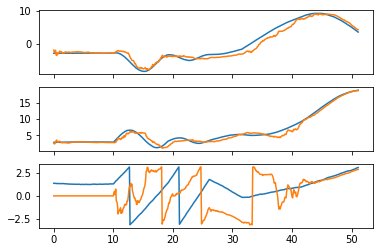

In [11]:
X = Data.X

fig,ax = plt.subplots(3,1,sharex=True)
Time = 0.1 * np.arange(len(X))
ax[0].plot(Time,X[:,0])
ax[0].plot(Time,Mu[:,0])
ax[1].plot(Time,X[:,1])
ax[1].plot(Time,Mu[:,1])

shiftAngle = lambda theta : ((theta + np.pi) % (2*np.pi)) -np.pi

ax[2].plot(Time,shiftAngle(X[:,2]))
ax[2].plot(Time,shiftAngle(Mu[:,2]))


# Final Score

You can run this code to see all of your scores.




In [ ]:
Assignment.showResults()




# Submission

Save your work and run this cell to submit. It will only work if you have the internet.

